In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from typing import Any, Iterable

import block_formats.experiments as E

def mean_and_stderr(samples: list[float]) -> tuple[float, float]:
    t = torch.tensor(samples)
    return t.mean().item(), t.std(correction=0).div(len(t)**.5).item()

/home/ubuntu/SquashedLlama/notebooks/20250127-FormatsCascade/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load results

In [54]:
fisher_sum = {r.config.model: r.summary.fisher for r in E.runs("20250422-fisher") if "fisher" in r.summary}
stats = {r.config.model: r.summary.weight_stats for r in E.runs("20250423-weight-stats")}
results_param_raw = E.runs("20250421-param-sensitivity")

## Normal perturbation

In [38]:
def get_results() -> Iterable[dict[str, Any]]:
    for r in results_param_raw:
        if r.config.test.type == "perturb_each_param" and "kl_div" in r.summary:
            yield dict(
                model=r.config.model,
                parameter=r.config.test.parameter,
                noise_scale=r.config.test.scale,
                rms=r.summary.rms,
                **dict(zip(["xent", "xent_stderr"], mean_and_stderr(r.summary.cross_entropy))),
                **dict(zip(["kl_div", "kl_div_stderr"], mean_and_stderr(r.summary.kl_div))),
            )

df = pd.DataFrame.from_records(list(get_results()))
df = df.assign(kl_div_prediction=df.apply(lambda s: fisher_sum[s.model][s.parameter] * (s.rms * s.noise_scale) ** 2 * 0.5, axis=1))
display(df.head())

,model,parameter,noise_scale,rms,xent,xent_stderr,kl_div,kl_div_stderr,kl_div_prediction
0,meta-llama/Llama-3.2-1B,model.embed_tokens.weight,1.0,0.021907,5.665540,0.061971,3.269323,0.034827,1.686613
1,meta-llama/Llama-3.2-1B,model.layers.0.self_attn.q_proj.weight,1.0,0.036875,2.201181,0.030339,0.006600,0.000154,0.005106
2,meta-llama/Llama-3.2-1B,model.layers.0.self_attn.k_proj.weight,1.0,0.047735,2.213488,0.030598,0.018991,0.000538,0.013732
3,meta-llama/Llama-3.2-1B,model.layers.0.self_attn.v_proj.weight,1.0,0.009144,2.325224,0.030303,0.129017,0.002315,0.052861
4,meta-llama/Llama-3.2-1B,model.layers.0.self_attn.o_proj.weight,1.0,0.011592,2.298957,0.030469,0.103616,0.001809,0.049644


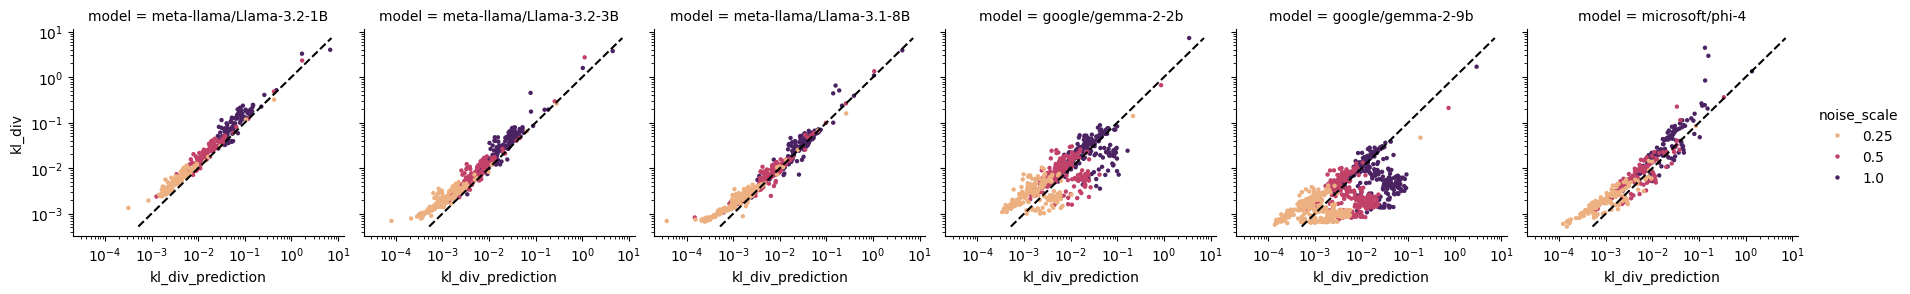

In [39]:
g = sns.relplot(data=df,#[df.model.apply(lambda m: "meta" in m)]
                y="kl_div", x="kl_div_prediction", col="model", hue="noise_scale", hue_norm=matplotlib.colors.LogNorm(), palette="flare", height=3, lw=0, s=10)
for ax in g.axes.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")
    xs = sorted(df["kl_div"])
    ax.plot(xs, xs, "k--")

## Quantisation

In [40]:
def get_results() -> Iterable[dict[str, Any]]:
    for r in results_param_raw:
        if r.config.test.type == "quantise_each_param" and "kl_div" in r.summary:
            yield dict(
                model=r.config.model,
                parameter=r.config.test.parameter,
                fmt=r.config.test.fmt_str,
                rmse=r.summary.rmse,
                rms=r.summary.rms,
                **dict(zip(["xent", "xent_stderr"], mean_and_stderr(r.summary.cross_entropy))),
                **dict(zip(["kl_div", "kl_div_stderr"], mean_and_stderr(r.summary.kl_div))),
            )

df = pd.DataFrame.from_records(list(get_results()))
df = df.assign(kl_div_prediction=df.apply(lambda s: fisher_sum[s.model][s.parameter] * (s.rmse) ** 2 * 0.5, axis=1))
df = df.assign(rmse_norm=df.rmse/df.rms)
df = df.assign(mse_norm=df.rmse_norm**2)
display(df.head())

,model,parameter,fmt,rmse,rms,xent,xent_stderr,kl_div,kl_div_stderr,kl_div_prediction,rmse_norm,mse_norm
0,meta-llama/Llama-3.2-1B,model.embed_tokens.weight,"E2M1{1,64:BFLOAT16:absmax}",0.002327,0.021907,2.214459,0.030470,0.017619,0.000141,0.019030,0.106221,0.011283
1,meta-llama/Llama-3.2-1B,model.layers.0.self_attn.q_proj.weight,"E2M1{1,64:BFLOAT16:absmax}",0.003952,0.036875,2.196001,0.030348,0.000895,0.000006,0.000059,0.107169,0.011485
2,meta-llama/Llama-3.2-1B,model.layers.0.self_attn.k_proj.weight,"E2M1{1,64:BFLOAT16:absmax}",0.005149,0.047735,2.196133,0.030343,0.000961,0.000007,0.000160,0.107871,0.011636
3,meta-llama/Llama-3.2-1B,model.layers.0.self_attn.v_proj.weight,"E2M1{1,64:BFLOAT16:absmax}",0.000979,0.009144,2.196386,0.030354,0.001345,0.000015,0.000606,0.107062,0.011462
4,meta-llama/Llama-3.2-1B,model.layers.0.self_attn.o_proj.weight,"E2M1{1,64:BFLOAT16:absmax}",0.001235,0.011592,2.196819,0.030366,0.001526,0.000022,0.000564,0.106555,0.011354


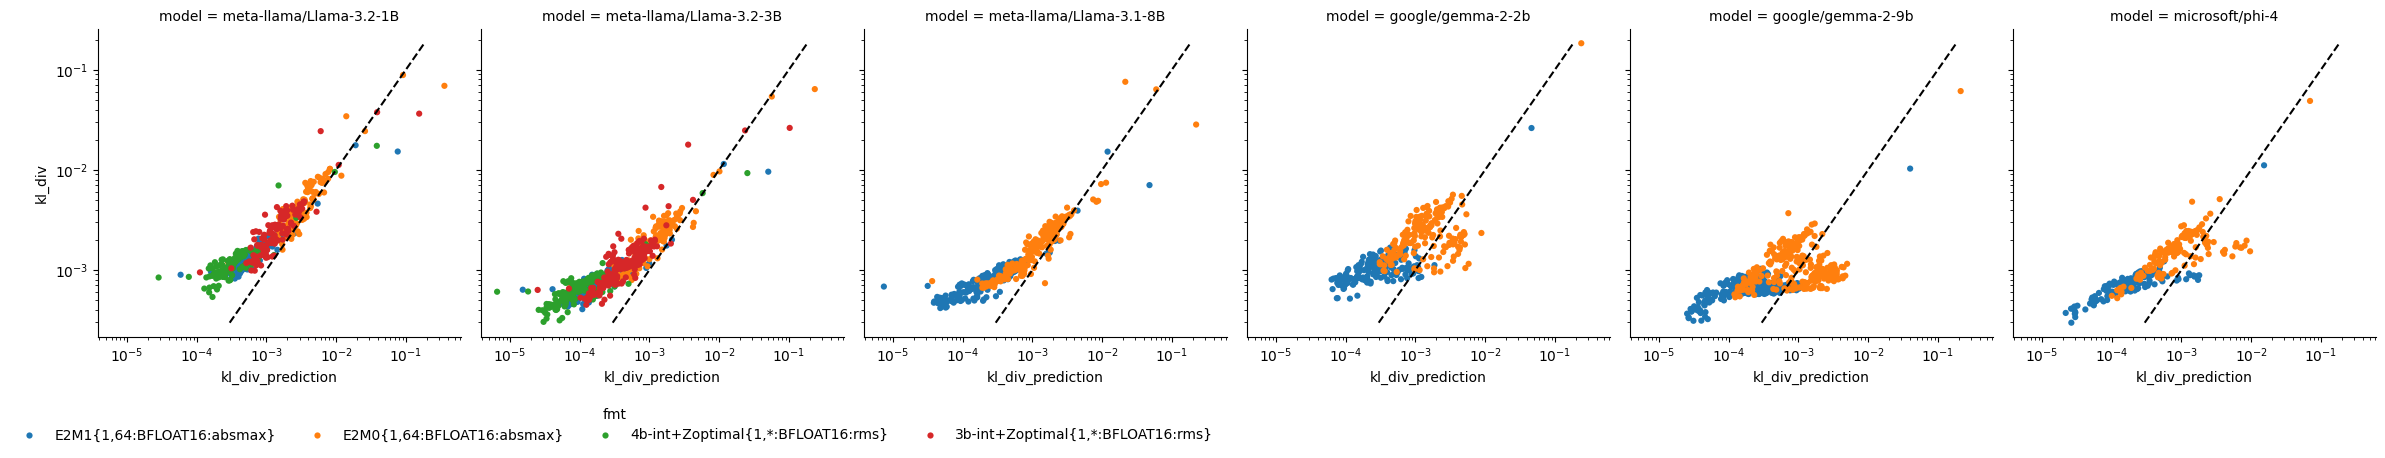

In [42]:
g = sns.relplot(data=df,#[df.model.apply(lambda m: "meta" in m)],
                y="kl_div", x="kl_div_prediction", col="model", hue="fmt", height=4, lw=0, s=20)
for ax in g.axes.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")
    xs = sorted(df["kl_div"])
    ax.plot(xs, xs, "k--")
sns.move_legend(g, loc="lower left", ncols=4, bbox_to_anchor=(0, -0.15, 1, 1))

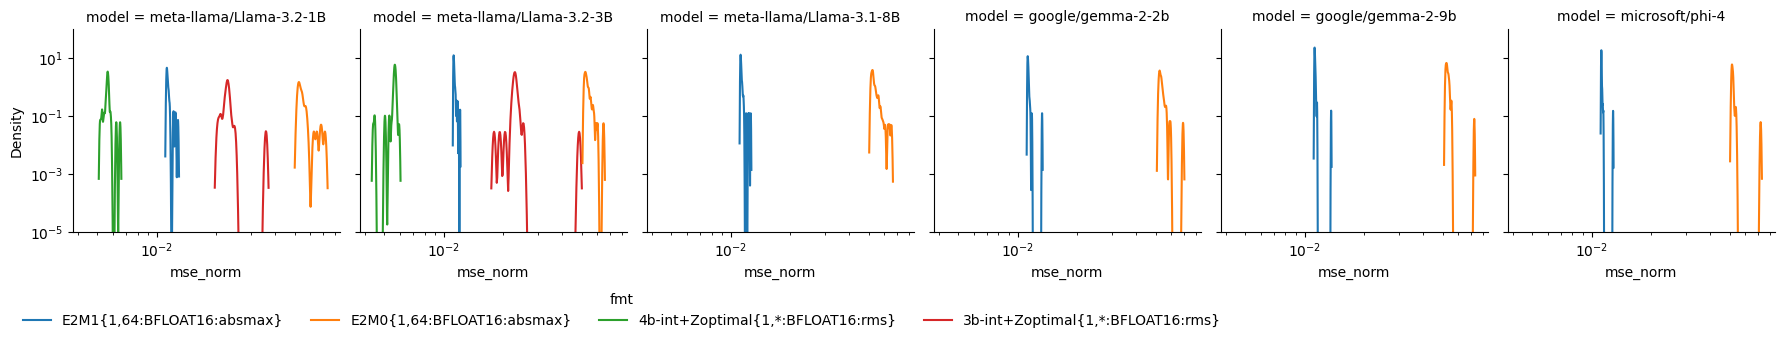

In [44]:
g = sns.displot(df, x="mse_norm", hue="fmt", col="model", kind="kde", log_scale=True, bw_adjust=0.5, height=3)
for ax in g.axes.flatten():
    ax.set_yscale("log")
    ax.set_ylim((10**-5, 10**2))
sns.move_legend(g, loc="lower left", ncols=4, bbox_to_anchor=(0, -0.15, 1, 1))

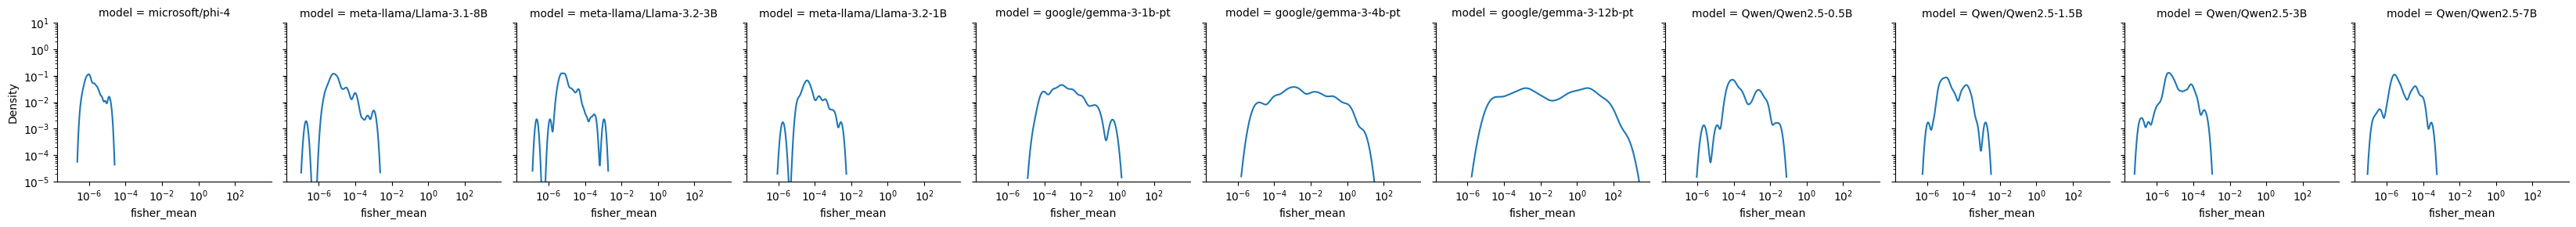

In [56]:
g = sns.displot(
    pd.DataFrame.from_records([dict(model=m, parameter=p, fisher_mean=f / int(math.prod(stats[m][p]["shape"])))
                               for m, d in fisher_sum.items()
                               for p, f in d.items()
                               if m in stats]),
    x="fisher_mean", col="model", kind="kde", log_scale=True, bw_adjust=0.5, height=3,
)
for ax in g.axes.flatten():
    ax.set_yscale("log")
    ax.set_ylim((10**-5, 10**1))